In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


Using TensorFlow backend.
/home/jerry/anaconda2/envs/tf35/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


38951745

## Data 
The data is pickled as an N_classes x n_examples x width x height array, and there is an accompanyng dictionary to specify which indexes belong to which languages.

In [2]:
PATH = "/home/jerry/Projects/keras-oneshot" #CHANGE THIS - path where the pickled data is stored

with open(os.path.join(PATH, "train.pickle"), "rb") as f:
    (X,c) = pickle.load(f)

with open(os.path.join(PATH, "val.pickle"), "rb") as f:
    (Xval,cval) = pickle.load(f)
    
print("training alphabets")
print(c.keys())
print("validation alphabets:")
print(cval.keys())

training alphabets
dict_keys(['00029_016', '00044_025', '00022_017', '00056_018', '00032_016', '00018_003', '00029_024', '00006_001', '00097_011', '00003_016', '00022_025', '00006_003', '00011_009', '00032_025', '00041_018', '00023_003', '00060_025', '00016_018', '00016_005', '00057_025', '00005_013', '00011_016', '00001_001', '00010_010', '00023_025', '00001_023', '00019_018', '00007_026', '00067_025', '00011_017', '00022_006', '00002_018', '00053_021', '00001_008', '00022_015', '00024_021', '00023_015', '00010_001', '00013_018', '00027_007', '00030_025', '00018_021', '00027_018', '00052_018', '00015_018', '00001_009', '00004_027', '00063_021', '00028_017', '00014_001', '00030_024', '00011_010', '00004_006', '00008_026', '00029_003', '00008_005', '00059_025', '00003_009', '00009_008', '00028_016', '00007_008', '00043_021', '00000_027', '00071_021', '00035_018', '00019_006', '00028_001', '00009_024', '00012_003', '00031_024', '00046_021', '00004_010', '00050_025', '00032_015', '00040_0

In [3]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h, 1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),
                            
                             )
    
    
#Instantiate the class
loader = Siamese_Loader(PATH)

loading data from /home/jerry/Projects/keras-oneshot/train.pickle
loading data from /home/jerry/Projects/keras-oneshot/val.pickle


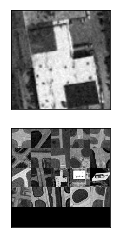

In [4]:

def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(20,"train")
plot_oneshot_task(pairs)


In [5]:

#Training loop
print("!")
evaluate_every = 1 # interval for evaluating on one-shot tasks
loss_every=50 # interval for printing loss (iterations)
batch_size = 32
n_iter = 90000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 #how mahy one-shot tasks to validate on?
best = -1
weights_path = os.path.join(PATH, "weights")
print("training")
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    print(loss)
    if i % evaluate_every == 0:
        print("evaluating")
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("saving")
            siamese_net.save(weights_path)
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))


!
training
4.5242
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 20.4% 20 way one-shot learning accuracy
saving
4.48561
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
saving
4.44728
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
4.38228
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
4.31781
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
4.26462
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
saving
4.22671
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20

Got an average of 68.0% 20 way one-shot learning accuracy
3.21528
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
3.29678
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
3.19289
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
3.26105
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.8% 20 way one-shot learning accuracy
3.12408
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
3.14839
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
3.15039
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...

Got an average of 82.8% 20 way one-shot learning accuracy
2.59994
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
2.5671
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
2.59022
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
2.57565
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
2.58037
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
2.5443
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
2.48421
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
G

Got an average of 74.4% 20 way one-shot learning accuracy
2.15575
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
2.18061
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
2.21123
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.4% 20 way one-shot learning accuracy
2.21318
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
2.16465
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
2.13994
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
2.10972
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...

Got an average of 84.4% 20 way one-shot learning accuracy
1.91877
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
1.86226
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.0% 20 way one-shot learning accuracy
1.95217
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.0% 20 way one-shot learning accuracy
1.89103
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
1.87952
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
1.89632
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
1.90063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...

Got an average of 77.2% 20 way one-shot learning accuracy
1.66589
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
1.6305
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
1.65077
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
1.57843
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
1.61512
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
1.59681
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
1.6241
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
G

Got an average of 88.8% 20 way one-shot learning accuracy
1.50827
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
1.50368
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 350, training loss: 1.50,
1.50159
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
1.42563
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
1.53121
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
1.50542
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
1.53383
evaluating
Evaluating model on 250 rando

Got an average of 89.2% 20 way one-shot learning accuracy
1.33434
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.8% 20 way one-shot learning accuracy
1.30432
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
1.33661
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
1.32891
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
1.30459
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
1.32183
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
1.33471
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...

Got an average of 83.2% 20 way one-shot learning accuracy
1.18419
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.0% 20 way one-shot learning accuracy
1.22883
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
1.39367
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
1.29184
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.2% 20 way one-shot learning accuracy
1.22598
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.8% 20 way one-shot learning accuracy
1.26898
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.6% 20 way one-shot learning accuracy
1.24521
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...

Got an average of 87.6% 20 way one-shot learning accuracy
1.16476
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
1.13272
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.0% 20 way one-shot learning accuracy
1.15256
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
1.27364
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.8% 20 way one-shot learning accuracy
1.20282
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
1.19747
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
1.11568
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...

Got an average of 88.4% 20 way one-shot learning accuracy
1.22992
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.8% 20 way one-shot learning accuracy
1.05875
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
1.0715
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
1.11172
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.2% 20 way one-shot learning accuracy
1.06405
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.8% 20 way one-shot learning accuracy
1.03094
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
1.08402
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...


Got an average of 91.6% 20 way one-shot learning accuracy
0.998817
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.2% 20 way one-shot learning accuracy
0.94961
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.0% 20 way one-shot learning accuracy
0.999188
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.0% 20 way one-shot learning accuracy
1.01768
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
1.10418
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.4% 20 way one-shot learning accuracy
1.01169
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.4% 20 way one-shot learning accuracy
1.00842
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks .

Got an average of 88.4% 20 way one-shot learning accuracy
0.938683
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
1.02605
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.6% 20 way one-shot learning accuracy
0.94431
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.8% 20 way one-shot learning accuracy
0.91888
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.0% 20 way one-shot learning accuracy
0.897973
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.923364
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.925264
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks

Got an average of 83.6% 20 way one-shot learning accuracy
iteration 750, training loss: 0.89,
0.887786
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
0.873992
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
0.84128
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
0.866884
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
0.848007
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
0.839743
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
0.816136
evaluating
Evaluating model on 250

Got an average of 89.2% 20 way one-shot learning accuracy
0.828459
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.2% 20 way one-shot learning accuracy
0.820417
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
0.819989
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
0.817668
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
0.831201
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.8% 20 way one-shot learning accuracy
0.839327
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
0.896009
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 82.4% 20 way one-shot learning accuracy
0.767901
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
0.82167
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
0.847768
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
0.801425
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
0.787586
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
0.749648
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
0.818792
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 90.0% 20 way one-shot learning accuracy
0.780777
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.6% 20 way one-shot learning accuracy
0.795893
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.4% 20 way one-shot learning accuracy
0.753684
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.2% 20 way one-shot learning accuracy
0.752929
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.751602
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.0% 20 way one-shot learning accuracy
0.760592
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
0.748074
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 88.8% 20 way one-shot learning accuracy
0.723568
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.2% 20 way one-shot learning accuracy
0.711303
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.70893
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.4% 20 way one-shot learning accuracy
0.664686
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.898447
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.716065
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.8063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks

Got an average of 86.4% 20 way one-shot learning accuracy
0.682201
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.6% 20 way one-shot learning accuracy
0.701536
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
0.695808
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
0.671867
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
0.679037
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
0.698982
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.0% 20 way one-shot learning accuracy
0.688677
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.6% 20 way one-shot learning accuracy
0.680839
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.663509
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.670574
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.2% 20 way one-shot learning accuracy
0.746752
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.0% 20 way one-shot learning accuracy
0.625561
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.2% 20 way one-shot learning accuracy
0.636639
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
0.655326
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 81.6% 20 way one-shot learning accuracy
0.599719
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 1150, training loss: 0.60,
0.649851
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
0.612342
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
0.62365
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
0.620744
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.6% 20 way one-shot learning accuracy
0.636693
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
0.58981
evaluating
Evaluating model on 250

Got an average of 94.0% 20 way one-shot learning accuracy
0.619826
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.595527
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.592231
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.680611
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.607289
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.620844
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.600306
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 92.8% 20 way one-shot learning accuracy
0.589203
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.586015
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.578478
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.565442
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.685455
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.58025
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.562973
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 94.8% 20 way one-shot learning accuracy
0.634812
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.570249
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.562518
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.6% 20 way one-shot learning accuracy
0.536844
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.520258
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.4% 20 way one-shot learning accuracy
0.56528
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.6% 20 way one-shot learning accuracy
0.591089
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 93.6% 20 way one-shot learning accuracy
0.538633
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.549227
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.8% 20 way one-shot learning accuracy
0.514704
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.534066
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.0% 20 way one-shot learning accuracy
0.526956
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.6% 20 way one-shot learning accuracy
0.531827
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.527497
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 88.0% 20 way one-shot learning accuracy
0.583556
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.0% 20 way one-shot learning accuracy
0.556435
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
0.488843
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.0% 20 way one-shot learning accuracy
0.512796
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.4% 20 way one-shot learning accuracy
0.516607
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
0.527297
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.0% 20 way one-shot learning accuracy
0.512988
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 89.2% 20 way one-shot learning accuracy
0.468685
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.463636
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.476219
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.0% 20 way one-shot learning accuracy
0.478458
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.489039
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.4% 20 way one-shot learning accuracy
0.496539
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.477246
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 87.6% 20 way one-shot learning accuracy
0.453453
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.6% 20 way one-shot learning accuracy
0.457558
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
iteration 1550, training loss: 0.46,
0.478828
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
0.463491
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.4% 20 way one-shot learning accuracy
0.463808
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
0.459738
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.446509
evaluating
Evaluating model on 2

Got an average of 94.8% 20 way one-shot learning accuracy
0.455168
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.480797
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.444624
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.46264
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.442341
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.437306
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.6% 20 way one-shot learning accuracy
0.545948
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 84.4% 20 way one-shot learning accuracy
0.434632
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.4% 20 way one-shot learning accuracy
0.421563
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.4% 20 way one-shot learning accuracy
0.420985
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.416451
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.6% 20 way one-shot learning accuracy
0.517122
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.419598
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.497088
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 91.2% 20 way one-shot learning accuracy
0.428764
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.6% 20 way one-shot learning accuracy
0.422676
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.404722
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.4% 20 way one-shot learning accuracy
0.421322
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
0.42601
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.8% 20 way one-shot learning accuracy
0.406624
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.6% 20 way one-shot learning accuracy
0.412786
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 94.0% 20 way one-shot learning accuracy
0.430512
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.400491
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.42932
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.417434
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.6% 20 way one-shot learning accuracy
0.395381
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.413078
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.428827
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 85.6% 20 way one-shot learning accuracy
0.40932
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.4% 20 way one-shot learning accuracy
0.384989
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.8% 20 way one-shot learning accuracy
0.431469
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
0.379452
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.8% 20 way one-shot learning accuracy
0.451286
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.6% 20 way one-shot learning accuracy
0.394749
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.8% 20 way one-shot learning accuracy
0.415543
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 93.2% 20 way one-shot learning accuracy
0.360723
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.467664
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.397432
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.376257
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.6% 20 way one-shot learning accuracy
0.457033
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.394869
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.398043
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 90.4% 20 way one-shot learning accuracy
0.354535
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.362854
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.35163
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.4% 20 way one-shot learning accuracy
iteration 1950, training loss: 0.35,
0.380392
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.2% 20 way one-shot learning accuracy
0.449825
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.6% 20 way one-shot learning accuracy
0.463199
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.407174
evaluating
Evaluating model on 25

Got an average of 93.6% 20 way one-shot learning accuracy
0.364392
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.376683
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.358892
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.368644
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.365081
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.355125
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.370943
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 92.4% 20 way one-shot learning accuracy
0.455391
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.358943
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.397875
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.410994
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.34818
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.39066
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.352816
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 93.2% 20 way one-shot learning accuracy
0.348022
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.339221
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.39722
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.361493
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.378916
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.331245
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.387223
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 91.2% 20 way one-shot learning accuracy
0.395185
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.329924
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.369479
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.330431
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.353332
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.3355
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.356904
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 94.4% 20 way one-shot learning accuracy
0.328104
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.315462
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.8% 20 way one-shot learning accuracy
0.448688
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.333295
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.337465
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.314618
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.4% 20 way one-shot learning accuracy
0.306811
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.4% 20 way one-shot learning accuracy
0.318426
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.338528
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.309802
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.367644
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.321138
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.365827
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.320408
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.0% 20 way one-shot learning accuracy
0.327913
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.326947
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.2% 20 way one-shot learning accuracy
0.324346
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.8% 20 way one-shot learning accuracy
0.296219
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
iteration 2350, training loss: 0.30,
0.341746
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.4% 20 way one-shot learning accuracy
0.277995
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.0% 20 way one-shot learning accuracy
0.310182
evaluating
Evaluating model on 2

Got an average of 96.4% 20 way one-shot learning accuracy
0.313698
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.318574
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.313454
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.287994
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.320065
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.0% 20 way one-shot learning accuracy
0.331942
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.341022
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 91.6% 20 way one-shot learning accuracy
0.331758
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.277807
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.291213
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.30304
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.31164
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.363786
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.285415
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 94.4% 20 way one-shot learning accuracy
0.27664
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.290626
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.31923
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.296172
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.287285
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.281266
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.291054
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 96.0% 20 way one-shot learning accuracy
0.296999
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.335769
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.31358
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.299077
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.296032
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.283275
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.297338
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 91.2% 20 way one-shot learning accuracy
0.317044
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.266356
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.301452
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.271623
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.285333
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.279059
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.275005
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 92.8% 20 way one-shot learning accuracy
0.290773
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.317036
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.314759
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.320227
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.294537
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.284559
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.330815
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 92.8% 20 way one-shot learning accuracy
0.293489
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.261538
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.322524
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.288727
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.278849
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
iteration 2750, training loss: 0.28,
0.277736
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.297411
evaluating
Evaluating model on 2

Got an average of 95.6% 20 way one-shot learning accuracy
0.290858
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.269082
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.275526
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.246746
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.269564
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.262936
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.239413
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 92.0% 20 way one-shot learning accuracy
0.267955
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.296163
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.282676
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.270247
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.256769
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.354696
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.261551
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.4% 20 way one-shot learning accuracy
0.245729
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.264386
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.2721
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.24956
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.249
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.233364
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.22818
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...

Got an average of 96.0% 20 way one-shot learning accuracy
0.259359
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.26628
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.262686
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.262339
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.8% 20 way one-shot learning accuracy
0.251708
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.282676
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.284625
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 93.6% 20 way one-shot learning accuracy
0.258543
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.272132
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.239178
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.240891
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.228848
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.258966
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.267937
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 92.8% 20 way one-shot learning accuracy
0.24707
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.268411
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.210154
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.240876
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.426483
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.229946
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.224718
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 92.4% 20 way one-shot learning accuracy
0.229581
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.301519
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.231317
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.219357
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.23699
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.205501
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
iteration 3150, training loss: 0.21,
0.259401
evaluating
Evaluating model on 25

Got an average of 95.2% 20 way one-shot learning accuracy
0.2306
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.210891
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.219746
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.236843
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.257879
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.232878
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.204322
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 95.2% 20 way one-shot learning accuracy
0.248343
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.245231
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.213345
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.237407
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.232118
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.234515
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.220992
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.8% 20 way one-shot learning accuracy
0.295118
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.255996
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.23896
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.226153
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.29236
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.236942
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.246584
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 96.0% 20 way one-shot learning accuracy
0.218166
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.237442
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.242855
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.213572
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.228893
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.216281
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.246339
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 97.6% 20 way one-shot learning accuracy
0.218939
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.219304
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.216305
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.270741
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.195896
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.232757
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.218713
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 96.0% 20 way one-shot learning accuracy
0.211749
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.24331
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.188105
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.188076
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.226578
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.233285
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.245976
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 92.8% 20 way one-shot learning accuracy
0.197978
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.204343
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.312556
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.241869
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.216791
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.234896
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.212731
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 93.6% 20 way one-shot learning accuracy
iteration 3600, training loss: 0.22,
0.219419
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.180381
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.209327
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.252979
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.21184
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.227432
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.20699
evaluating
Evaluating model on 250

Got an average of 93.6% 20 way one-shot learning accuracy
0.270601
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.195084
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.0% 20 way one-shot learning accuracy
0.201892
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.232041
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.202878
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.238051
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.19046
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 98.8% 20 way one-shot learning accuracy
0.233787
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.241875
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.196704
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.198082
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.194618
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.187324
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.19522
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 94.4% 20 way one-shot learning accuracy
0.197052
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.20374
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.247271
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.212796
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.188849
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.214107
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.187179
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 95.2% 20 way one-shot learning accuracy
0.182688
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.201534
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.198689
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.175774
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.239259
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.192192
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.199768
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.2% 20 way one-shot learning accuracy
0.186074
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.241288
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.235081
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.19959
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.216141
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.218701
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.225397
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 92.8% 20 way one-shot learning accuracy
0.242271
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.214808
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.0% 20 way one-shot learning accuracy
0.200411
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.4% 20 way one-shot learning accuracy
0.213618
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.6% 20 way one-shot learning accuracy
0.201349
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.0% 20 way one-shot learning accuracy
0.216619
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.6% 20 way one-shot learning accuracy
0.176476
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.2% 20 way one-shot learning accuracy
0.183516
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
iteration 4000, training loss: 0.18,
0.183569
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.173763
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.184571
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.198409
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.203026
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.202362
evaluating
Evaluating model on 2

Got an average of 95.2% 20 way one-shot learning accuracy
0.213951
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.204007
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.212464
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.191661
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.206956
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.172883
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.175734
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.2% 20 way one-shot learning accuracy
0.216657
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.174772
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.249036
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.18574
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.193455
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.186455
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.213553
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 95.2% 20 way one-shot learning accuracy
0.189699
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.18595
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.199591
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.201031
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.186638
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.190336
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.237617
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 91.2% 20 way one-shot learning accuracy
0.176084
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.209038
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.188081
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.241393
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.29555
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.193473
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.188664
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 89.2% 20 way one-shot learning accuracy
0.203743
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.182437
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.166615
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.214022
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.6% 20 way one-shot learning accuracy
0.18642
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.203394
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.173074
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 92.0% 20 way one-shot learning accuracy
0.187197
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.8% 20 way one-shot learning accuracy
0.17332
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.209439
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.272345
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.183491
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.20122
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.175073
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 95.2% 20 way one-shot learning accuracy
0.225559
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.198285
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
iteration 4400, training loss: 0.20,
0.161564
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.257942
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.318387
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.19087
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.169685
evaluating
Evaluating model on 25

Got an average of 96.0% 20 way one-shot learning accuracy
0.184849
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.185836
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.177952
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.343292
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.175787
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.19007
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.195872
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 89.2% 20 way one-shot learning accuracy
0.179781
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.18934
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.171885
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.22109
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.17466
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.161122
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.18223
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks 

Got an average of 91.6% 20 way one-shot learning accuracy
0.193992
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.4% 20 way one-shot learning accuracy
0.210463
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.177308
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.166306
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.26645
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.182397
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.218327
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 96.0% 20 way one-shot learning accuracy
0.250214
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.211302
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.200722
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.159594
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.183724
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.345437
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.174747
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.4% 20 way one-shot learning accuracy
0.231893
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.195645
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.179481
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.177882
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.16617
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.218213
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.189121
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 96.0% 20 way one-shot learning accuracy
0.182886
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.183678
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.197102
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.187873
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.170367
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.178078
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.179335
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.4% 20 way one-shot learning accuracy
0.170503
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.173325
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.184281
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
iteration 4800, training loss: 0.18,
0.2832
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.181836
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.186221
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.175073
evaluating
Evaluating model on 250

Got an average of 95.2% 20 way one-shot learning accuracy
0.189778
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.168648
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.151818
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.174343
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.183785
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.163092
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.154595
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 96.8% 20 way one-shot learning accuracy
0.218683
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.202591
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.221007
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.151014
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.272845
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.172606
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.207756
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 90.4% 20 way one-shot learning accuracy
0.198354
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.270615
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.0% 20 way one-shot learning accuracy
0.164967
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.166711
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.164913
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.15417
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.191034
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 97.2% 20 way one-shot learning accuracy
0.156286
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.172731
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.1653
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.165874
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.229635
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.164217
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.197725
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 96.8% 20 way one-shot learning accuracy
0.188821
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.175749
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.162239
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.166565
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.146157
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.17075
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.165359
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 95.6% 20 way one-shot learning accuracy
0.15402
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.153126
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.160406
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.183256
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.167938
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.15307
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.170401
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 94.0% 20 way one-shot learning accuracy
0.15629
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.21594
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.150075
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.153175
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
iteration 5200, training loss: 0.15,
0.303352
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.145843
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.292291
evaluating
Evaluating model on 250

Got an average of 93.2% 20 way one-shot learning accuracy
0.147091
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.198059
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.200104
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.169157
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.229546
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.160404
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.169389
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.2% 20 way one-shot learning accuracy
0.163448
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.189961
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.176346
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.177624
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.149875
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.167052
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.185467
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 92.8% 20 way one-shot learning accuracy
0.156559
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.164754
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.198522
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.294626
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.1599
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.148111
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.151258
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 94.0% 20 way one-shot learning accuracy
0.196834
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.183122
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.165092
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.161559
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.139994
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.140863
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.6% 20 way one-shot learning accuracy
0.17808
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 94.0% 20 way one-shot learning accuracy
0.196675
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.159373
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.151574
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.139375
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.149096
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.16879
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.155604
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 96.8% 20 way one-shot learning accuracy
0.142046
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.154918
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.16496
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.8% 20 way one-shot learning accuracy
0.159495
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.156296
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.153833
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.145714
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 96.8% 20 way one-shot learning accuracy
0.152858
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.145422
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.154888
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.150999
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.158271
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
iteration 5600, training loss: 0.16,
0.153395
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.151606
evaluating
Evaluating model on 2

Got an average of 98.4% 20 way one-shot learning accuracy
0.155525
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.145381
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.285207
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.181178
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.163558
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.144136
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.154182
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.0% 20 way one-shot learning accuracy
0.282325
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.146301
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.13676
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.142065
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.15602
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.140687
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.150769
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 93.6% 20 way one-shot learning accuracy
0.133926
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.147508
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.136505
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.142108
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.167085
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.2% 20 way one-shot learning accuracy
0.149952
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.148669
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.2% 20 way one-shot learning accuracy
0.152705
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.164749
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.166159
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.176595
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.125128
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.139819
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.175994
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.4% 20 way one-shot learning accuracy
0.175543
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.333602
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.153864
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.158114
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.207642
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.211178
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.286925
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 98.4% 20 way one-shot learning accuracy
0.162608
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.139718
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.163299
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.15134
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.128927
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.151984
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.156923
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 98.8% 20 way one-shot learning accuracy
0.142277
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.151478
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.149738
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.167869
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.133007
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.171691
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
iteration 6000, training loss: 0.17,
0.138249
evaluating
Evaluating model on 2

Got an average of 96.4% 20 way one-shot learning accuracy
0.162413
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.161355
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.163583
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.121102
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.159945
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.152467
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.139902
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 93.2% 20 way one-shot learning accuracy
0.148495
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.146462
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.142077
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.148928
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.172202
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.148914
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.156695
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 97.2% 20 way one-shot learning accuracy
0.151546
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.149414
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.26207
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.142369
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.146362
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.130256
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.16773
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 97.2% 20 way one-shot learning accuracy
0.162041
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.131849
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.182862
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.140109
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.148358
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.173062
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.166398
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 93.2% 20 way one-shot learning accuracy
0.120176
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.159782
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.1388
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.121279
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.130758
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.144178
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.126371
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 97.6% 20 way one-shot learning accuracy
0.165734
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.154179
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.141745
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.139986
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.14387
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.133367
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.154258
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 96.0% 20 way one-shot learning accuracy
0.144649
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.133356
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.127666
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.165356
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.150096
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.135039
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.131378
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 93.6% 20 way one-shot learning accuracy
iteration 6450, training loss: 0.15,
0.177613
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.162648
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.152093
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.150437
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.136714
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.150856
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.125631
evaluating
Evaluating model on 2

Got an average of 97.2% 20 way one-shot learning accuracy
0.165854
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.149571
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.140579
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.169071
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.135759
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.142377
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.130735
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.6% 20 way one-shot learning accuracy
0.145771
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.148617
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.140914
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.119387
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.206943
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.144827
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.127084
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 92.8% 20 way one-shot learning accuracy
0.154795
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.149075
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.163551
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.0% 20 way one-shot learning accuracy
0.153825
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.165605
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.121136
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.165841
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 96.8% 20 way one-shot learning accuracy
0.178351
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.161671
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.145793
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.164872
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.152968
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.135012
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.156948
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 97.2% 20 way one-shot learning accuracy
0.154197
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.127612
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.139637
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.120525
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.116853
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.167828
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.13198
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 96.4% 20 way one-shot learning accuracy
0.177921
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.135686
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.128947
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.14053
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.153334
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.120513
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.141936
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 96.4% 20 way one-shot learning accuracy
0.129804
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
iteration 6850, training loss: 0.13,
0.145184
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.154172
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.148972
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.12997
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.20853
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.153336
evaluating
Evaluating model on 250

Got an average of 95.6% 20 way one-shot learning accuracy
0.206031
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.144594
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.128437
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.156645
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.143342
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.145603
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.194062
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 93.2% 20 way one-shot learning accuracy
0.134924
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.150567
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.32285
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.304822
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.130463
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.153219
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.124379
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 94.8% 20 way one-shot learning accuracy
0.169307
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.150397
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.0% 20 way one-shot learning accuracy
0.147639
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.186715
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.147581
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.136886
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.149087
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.8% 20 way one-shot learning accuracy
0.152078
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.1273
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.145853
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.139131
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.119937
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.146502
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.128136
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 93.6% 20 way one-shot learning accuracy
0.15644
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.6% 20 way one-shot learning accuracy
0.144371
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.153274
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.154474
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.4% 20 way one-shot learning accuracy
0.156233
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.132682
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.240996
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 91.6% 20 way one-shot learning accuracy
0.131283
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.352534
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 89.6% 20 way one-shot learning accuracy
0.149332
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.12954
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.153687
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.143835
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.122393
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 96.0% 20 way one-shot learning accuracy
0.131589
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.127771
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
iteration 7250, training loss: 0.13,
0.13627
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.163668
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.234329
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.170603
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.13863
evaluating
Evaluating model on 250

Got an average of 94.8% 20 way one-shot learning accuracy
0.151056
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.135297
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.146345
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.11881
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.143681
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.152882
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.188098
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 94.8% 20 way one-shot learning accuracy
0.122144
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.162605
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.142076
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.154063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.139328
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.120845
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.247914
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 98.8% 20 way one-shot learning accuracy
0.154057
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.143576
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.143394
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.149809
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.145551
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.148224
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.173648
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 93.6% 20 way one-shot learning accuracy
0.150319
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.131987
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.143728
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 99.2% 20 way one-shot learning accuracy
0.148596
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.161772
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.137466
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.154037
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 97.2% 20 way one-shot learning accuracy
0.138377
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.137243
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.153922
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.129345
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.140749
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.15095
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.146052
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 94.0% 20 way one-shot learning accuracy
0.136967
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.152112
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.160878
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.205481
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.130224
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.125656
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.154441
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 97.6% 20 way one-shot learning accuracy
0.115065
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.137071
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.161022
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
iteration 7650, training loss: 0.16,
0.149352
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.151452
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.8% 20 way one-shot learning accuracy
0.138909
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.118443
evaluating
Evaluating model on 2

Got an average of 93.6% 20 way one-shot learning accuracy
0.142025
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.11331
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.151731
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.128816
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.164302
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.136718
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.134351
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 98.4% 20 way one-shot learning accuracy
0.32977
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.13658
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.164696
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.145496
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.17573
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.170044
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.137243
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks

Got an average of 92.8% 20 way one-shot learning accuracy
0.151451
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.13306
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.144871
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.126841
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.153574
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.244196
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.142518
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 92.4% 20 way one-shot learning accuracy
0.139475
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.157155
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.163532
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.147923
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.156206
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.126009
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.155364
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.8% 20 way one-shot learning accuracy
0.130456
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.168614
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.117317
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.140348
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.136746
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.15485
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.158113
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 98.4% 20 way one-shot learning accuracy
0.128338
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.153319
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.123152
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.147577
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.155482
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.13923
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.142849
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 95.2% 20 way one-shot learning accuracy
0.161931
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.121002
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.142287
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.128165
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
iteration 8050, training loss: 0.13,
0.163595
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.144146
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.199282
evaluating
Evaluating model on 2

Got an average of 96.0% 20 way one-shot learning accuracy
0.132079
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.199677
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.128595
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.120913
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.134191
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.144044
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.152124
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 97.2% 20 way one-shot learning accuracy
0.136652
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.157948
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.125377
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.129792
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.112072
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.119456
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.126515
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.6% 20 way one-shot learning accuracy
0.147353
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.151913
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.8% 20 way one-shot learning accuracy
0.143037
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.11406
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.132211
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.129675
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.117599
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 94.0% 20 way one-shot learning accuracy
0.12277
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.118617
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.118534
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.160278
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.145277
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.122629
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.119448
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 94.8% 20 way one-shot learning accuracy
0.151741
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.121474
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.121063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.13054
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.166618
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.128961
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.131192
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 96.0% 20 way one-shot learning accuracy
0.124539
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.116681
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.131351
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.126596
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.118044
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.147443
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.133502
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.2% 20 way one-shot learning accuracy
0.149155
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.127447
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.13118
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.121378
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.122772
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
iteration 8450, training loss: 0.12,
0.148188
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.125571
evaluating
Evaluating model on 25

Got an average of 95.2% 20 way one-shot learning accuracy
0.127434
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.137154
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.134163
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.114503
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.141635
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.161552
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.118815
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.8% 20 way one-shot learning accuracy
0.120885
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.115405
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.11227
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.159899
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.139661
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.107886
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.123207
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 96.4% 20 way one-shot learning accuracy
0.12663
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.104568
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.140258
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.122281
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.132108
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.140196
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.16443
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 96.0% 20 way one-shot learning accuracy
0.125043
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.116874
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.137019
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.10856
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.124324
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.125156
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.109732
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 95.6% 20 way one-shot learning accuracy
0.139685
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.169783
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.141605
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.134017
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.142338
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.146842
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.125578
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.2% 20 way one-shot learning accuracy
0.136932
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.151259
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.142396
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.135093
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.135827
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.155316
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.140801
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 96.0% 20 way one-shot learning accuracy
0.136232
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.144026
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.150591
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.12432
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.16145
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.139505
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
iteration 8850, training loss: 0.14,
0.143348
evaluating
Evaluating model on 250

Got an average of 97.6% 20 way one-shot learning accuracy
0.142415
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.168515
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.8% 20 way one-shot learning accuracy
0.132028
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.135374
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.147015
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.156927
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.122839
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.0% 20 way one-shot learning accuracy
0.123562
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.135364
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.113959
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.127608
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.129278
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
0.130764
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.4% 20 way one-shot learning accuracy
0.147274
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.0% 20 way one-shot learning accuracy
0.15825
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.10923
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.124678
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.127037
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.135668
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.133713
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.135311
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 94.4% 20 way one-shot learning accuracy
0.307141
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.136638
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.135679
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.139835
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.134211
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.135307
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.140593
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.2% 20 way one-shot learning accuracy
0.120411
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.117461
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.150343
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.121244
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.142573
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.145146
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.148845
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 97.6% 20 way one-shot learning accuracy
0.13962
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.118728
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.122178
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.120895
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.121801
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.11039
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.133616
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 96.8% 20 way one-shot learning accuracy
0.318681
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.128456
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.113101
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.13704
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.2398
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.148697
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.137798
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks

Got an average of 94.0% 20 way one-shot learning accuracy
iteration 9300, training loss: 0.12,
0.125893
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.118255
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.153219
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.120829
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.122197
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.129799
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.140114
evaluating
Evaluating model on 2

Got an average of 95.6% 20 way one-shot learning accuracy
0.165579
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.110917
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.121017
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.112219
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.131095
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.141467
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.140918
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 97.2% 20 way one-shot learning accuracy
0.119272
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.15482
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.133447
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.132264
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.167974
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.11663
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.121065
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 98.0% 20 way one-shot learning accuracy
0.130228
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.119798
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.224114
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.116163
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.111886
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.144587
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.132445
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 96.0% 20 way one-shot learning accuracy
0.133272
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.115935
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.11065
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.207074
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.12319
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.139029
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.146414
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 97.6% 20 way one-shot learning accuracy
0.15273
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.129297
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.112601
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.127383
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.119368
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.124549
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.122682
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 96.4% 20 way one-shot learning accuracy
0.133534
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.11981
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.129135
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.130918
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.8% 20 way one-shot learning accuracy
0.116423
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.123777
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.140284
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 94.4% 20 way one-shot learning accuracy
0.109821
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
iteration 9700, training loss: 0.11,
0.170024
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.144479
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.110343
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.132965
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.142298
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.120566
evaluating
Evaluating model on 2

Got an average of 95.6% 20 way one-shot learning accuracy
0.157243
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.152931
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.138506
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.113088
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.202018
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.148541
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.132244
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.6% 20 way one-shot learning accuracy
0.125616
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.121348
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.142242
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.112063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.145385
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.123569
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.113303
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.8% 20 way one-shot learning accuracy
0.118409
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.126063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.145832
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.0986431
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.134077
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.102868
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.13614
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 96.0% 20 way one-shot learning accuracy
0.114366
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.108947
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.133182
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.108866
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.103777
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.286249
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.108468
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 97.6% 20 way one-shot learning accuracy
0.115816
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.11731
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.133065
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 99.6% 20 way one-shot learning accuracy
0.120651
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.115102
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.10953
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.107633
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 95.2% 20 way one-shot learning accuracy
0.105868
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.107841
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.133516
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.136042
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 99.2% 20 way one-shot learning accuracy
0.120908
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.131198
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.10844
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 96.4% 20 way one-shot learning accuracy
0.120106
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.13325
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
iteration 10100, training loss: 0.13,
0.142147
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.101065
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.106063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.251903
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.125444
evaluating
Evaluating model on 2

Got an average of 95.2% 20 way one-shot learning accuracy
0.109295
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.102047
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.107149
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.129395
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.102899
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.111419
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.121545
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 93.2% 20 way one-shot learning accuracy
0.108144
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.119803
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.102221
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.118285
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.117
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.118066
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.103134
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks

Got an average of 96.8% 20 way one-shot learning accuracy
0.114606
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.115941
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.125855
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.116673
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.127184
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.8% 20 way one-shot learning accuracy
0.148701
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.123678
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.4% 20 way one-shot learning accuracy
0.148443
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.112972
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.109729
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.112763
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.135657
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.167168
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.120398
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 92.8% 20 way one-shot learning accuracy
0.0996186
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.105971
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.0983719
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.110288
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.10062
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.120224
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.147518
evaluating
Evaluating model on 250 random 20 way one-shot learning t

Got an average of 96.4% 20 way one-shot learning accuracy
0.120432
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.107643
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.0994473
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.114736
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.104659
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.125239
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.12049
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.2% 20 way one-shot learning accuracy
0.117196
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.8% 20 way one-shot learning accuracy
0.122218
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.119564
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
iteration 10500, training loss: 0.12,
0.0986845
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.112493
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.121403
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.202168
evaluating
Evaluating model on

Got an average of 95.6% 20 way one-shot learning accuracy
0.116857
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.157092
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.150293
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.139304
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.108615
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.113282
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.146992
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 91.6% 20 way one-shot learning accuracy
0.111972
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.116163
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.11388
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.155261
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.10947
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.107589
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.125381
evaluating
Evaluating model on 250 random 20 way one-shot learning task

Got an average of 94.8% 20 way one-shot learning accuracy
0.105525
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.129099
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.107172
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.121434
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.6% 20 way one-shot learning accuracy
0.114571
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.117095
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.109653
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 93.6% 20 way one-shot learning accuracy
0.0937653
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.103386
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.0992503
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.116678
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.099442
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.124937
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.0967901
evaluating
Evaluating model on 250 random 20 way one-shot learning

Got an average of 94.8% 20 way one-shot learning accuracy
0.148827
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.136346
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.108133
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.106458
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.0949251
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.107495
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.11215
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.8% 20 way one-shot learning accuracy
0.114027
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.104036
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.108777
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.243364
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.103161
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.0929934
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.106215
evaluating
Evaluating model on 250 random 20 way one-shot learning t

Got an average of 94.8% 20 way one-shot learning accuracy
0.113632
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.117666
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.132459
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.118964
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
iteration 10900, training loss: 0.12,
0.0942043
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.102913
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.132946
evaluating
Evaluating model on

Got an average of 95.6% 20 way one-shot learning accuracy
0.113655
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.093008
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.111482
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.112801
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.103527
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.109771
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.173879
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.6% 20 way one-shot learning accuracy
0.10202
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.110059
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.114334
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.151775
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.105113
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.126027
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.142423
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 94.4% 20 way one-shot learning accuracy
0.119594
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.112191
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.111016
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.112234
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.105109
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.105726
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.110242
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.2% 20 way one-shot learning accuracy
0.135931
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.4% 20 way one-shot learning accuracy
0.104206
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.0995505
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.101235
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.107978
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.0930631
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.116793
evaluating
Evaluating model on 250 random 20 way one-shot learning 

Got an average of 95.6% 20 way one-shot learning accuracy
0.127133
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.0924232
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.135635
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.104872
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.117093
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.103281
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.104765
evaluating
Evaluating model on 250 random 20 way one-shot learning t

Got an average of 96.0% 20 way one-shot learning accuracy
0.107052
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.12843
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.114525
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.109074
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.108513
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.117724
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.102726
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 95.2% 20 way one-shot learning accuracy
0.149352
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.109215
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.136699
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.107816
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.124818
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
iteration 11300, training loss: 0.12,
0.158198
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.11826
evaluating
Evaluating model on 2

Got an average of 96.0% 20 way one-shot learning accuracy
0.112752
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.117277
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.0987942
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.124243
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.100419
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.113046
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.126758
evaluating
Evaluating model on 250 random 20 way one-shot learning t

Got an average of 96.4% 20 way one-shot learning accuracy
0.118807
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.111809
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.105229
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.126323
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.110651
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.108783
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.0931128
evaluating
Evaluating model on 250 random 20 way one-shot learning t

Got an average of 98.4% 20 way one-shot learning accuracy
0.121705
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.108991
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.0962719
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.155472
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.0947575
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.0951749
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.0950398
evaluating
Evaluating model on 250 random 20 way one-shot learnin

Got an average of 97.2% 20 way one-shot learning accuracy
0.114583
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.134261
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.127738
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.0930001
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.114362
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 90.0% 20 way one-shot learning accuracy
0.102973
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.119523
evaluating
Evaluating model on 250 random 20 way one-shot learning t

Got an average of 96.0% 20 way one-shot learning accuracy
0.11415
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.0984017
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.144479
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.113804
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.129771
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.101358
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.184965
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 96.0% 20 way one-shot learning accuracy
0.116672
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.103688
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.1188
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.0975136
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.117108
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.0942678
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.124471
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.4% 20 way one-shot learning accuracy
0.126015
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.0965834
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.126331
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.115101
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.122683
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.0979881
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
iteration 11700, training loss: 0.10,
0.11234
evaluating
Evaluating model on

Got an average of 94.4% 20 way one-shot learning accuracy
0.124955
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.114371
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.120889
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.139528
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.099763
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.103429
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.137935
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 95.2% 20 way one-shot learning accuracy
0.127672
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.13125
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.0993703
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.106841
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 91.2% 20 way one-shot learning accuracy
0.122222
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.102846
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.113137
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 94.8% 20 way one-shot learning accuracy
0.100833
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.127091
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.123036
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.113484
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.106049
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.126013
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.122551
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 96.8% 20 way one-shot learning accuracy
0.116379
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.105571
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.116641
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.101156
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.122877
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.113217
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.0951225
evaluating
Evaluating model on 250 random 20 way one-shot learning t

Got an average of 97.6% 20 way one-shot learning accuracy
0.0977213
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.0999743
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.112432
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.105659
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.195094
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.126693
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.106202
evaluating
Evaluating model on 250 random 20 way one-shot learning 

Got an average of 97.6% 20 way one-shot learning accuracy
0.127845
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.102062
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.111652
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.110307
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.109311
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.119648
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.135468
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 96.4% 20 way one-shot learning accuracy
0.11262
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.104635
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.158133
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.113087
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.0972885
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.234063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.123341
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 96.4% 20 way one-shot learning accuracy
iteration 12150, training loss: 0.11,
0.102002
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.100263
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.135971
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.109398
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.125453
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.0% 20 way one-shot learning accuracy
0.113319
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.138869
evaluating
Evaluating model on 

Got an average of 97.2% 20 way one-shot learning accuracy
0.101398
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.125275
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.10782
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.118414
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.105556
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.135152
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.113109
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 97.2% 20 way one-shot learning accuracy
0.119872
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.112777
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.13239
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.242535
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.123656
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.8% 20 way one-shot learning accuracy
0.123844
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.174232
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 96.4% 20 way one-shot learning accuracy
0.114282
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.133167
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.131814
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.0969776
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.117897
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.117622
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.119665
evaluating
Evaluating model on 250 random 20 way one-shot learning t

Got an average of 95.6% 20 way one-shot learning accuracy
0.105555
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.101369
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.116507
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.111544
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.0997621
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.105822
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.102974
evaluating
Evaluating model on 250 random 20 way one-shot learning t

Got an average of 98.0% 20 way one-shot learning accuracy
0.132861
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.108609
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.111369
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.127739
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.108429
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.108327
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.0999256
evaluating
Evaluating model on 250 random 20 way one-shot learning t

Got an average of 95.6% 20 way one-shot learning accuracy
0.10318
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.102482
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.0957646
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.128016
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.104422
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.104398
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.147669
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 96.0% 20 way one-shot learning accuracy
0.116442
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
iteration 12550, training loss: 0.12,
0.106656
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.0993428
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.121901
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.102761
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.109263
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.106652
evaluating
Evaluating model on

Got an average of 97.2% 20 way one-shot learning accuracy
0.0963542
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.110545
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.0881311
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.116972
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.110818
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.0996763
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.0930212
evaluating
Evaluating model on 250 random 20 way one-shot learnin

Got an average of 98.4% 20 way one-shot learning accuracy
0.132351
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.0% 20 way one-shot learning accuracy
0.100258
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.0976367
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.236235
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.302138
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.139121
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.102103
evaluating
Evaluating model on 250 random 20 way one-shot learning t

Got an average of 95.6% 20 way one-shot learning accuracy
0.112204
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.162792
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.174168
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.128275
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.6% 20 way one-shot learning accuracy
0.100308
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.143167
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.115737
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 91.2% 20 way one-shot learning accuracy
0.103942
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.152662
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.8% 20 way one-shot learning accuracy
0.121352
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.101112
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.8% 20 way one-shot learning accuracy
0.114572
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.114952
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 96.4% 20 way one-shot learning accuracy
0.124456
evaluating
Evaluating model on 250 random 20 way one-shot learning ta

Got an average of 96.4% 20 way one-shot learning accuracy
0.143248
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.116301
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.128627
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.4% 20 way one-shot learning accuracy
0.133559
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.117938
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
0.20032
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 98.0% 20 way one-shot learning accuracy
0.108521
evaluating
Evaluating model on 250 random 20 way one-shot learning tas

Got an average of 95.6% 20 way one-shot learning accuracy
0.144677
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.135957
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.2% 20 way one-shot learning accuracy
0.126251
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.4% 20 way one-shot learning accuracy
0.123332
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.2% 20 way one-shot learning accuracy
0.135083
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.0994874
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.104581
evaluating
Evaluating model on 250 random 20 way one-shot learning t

Got an average of 95.2% 20 way one-shot learning accuracy
0.110384
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.0% 20 way one-shot learning accuracy
0.110032
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 97.6% 20 way one-shot learning accuracy
iteration 12950, training loss: 0.11,
0.120486
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 92.4% 20 way one-shot learning accuracy
0.097993
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 95.6% 20 way one-shot learning accuracy
0.11418
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 94.8% 20 way one-shot learning accuracy
0.104128
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 93.2% 20 way one-shot learning accuracy
0.129389
evaluating
Evaluating model on 2

KeyboardInterrupt: 

Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 1 way one-shot learning tasks ...
Evaluating model on 450 random 3 way one-shot learning tasks ...
Got an average of 99.77777777777777% 3 way one-shot learning accuracy
Evaluating model on 450 random 3 way one-shot learning tasks ...
Got an average of 100.0% 3 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 3 way one-shot learning tasks ...
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an average of 99.77777777777777% 5 way one-shot learning accuracy
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an average of 99.77777777777777% 5 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 5 way one-shot learning tasks

Evaluating model on 450 random 49 way one-shot learning tasks ...
Got an average of 88.88888888888889% 49 way one-shot learning accuracy
Evaluating model on 450 random 49 way one-shot learning tasks ...
Got an average of 99.33333333333333% 49 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 49 way one-shot learning tasks ...
Evaluating model on 450 random 51 way one-shot learning tasks ...
Got an average of 88.0% 51 way one-shot learning accuracy
Evaluating model on 450 random 51 way one-shot learning tasks ...
Got an average of 98.22222222222223% 51 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 51 way one-shot learning tasks ...
Evaluating model on 450 random 53 way one-shot learning tasks ...
Got an average of 90.22222222222223% 53 way one-shot learning accuracy
Evaluating model on 450 random 53 way one-shot learning tasks ...
Got an average of 98.88888888888889% 53 way one-shot learning accuracy
Evaluating nearest neighbour on 450

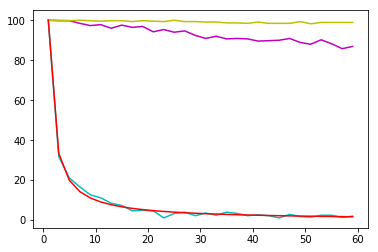

In [6]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 60, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

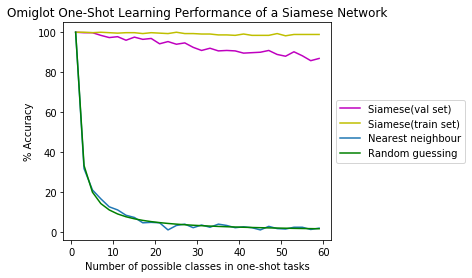

(20, 105, 105, 1)


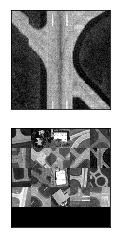

[[  1.14339279e-07]
 [  1.55591451e-07]
 [  7.15339921e-09]
 [  6.28358466e-05]
 [  4.18634454e-06]
 [  3.75629228e-04]
 [  7.11593917e-03]
 [  2.48679504e-01]
 [  3.97291500e-04]
 [  8.77867639e-01]
 [  7.55858196e-07]
 [  1.20710128e-03]
 [  1.24869766e-02]
 [  8.67302788e-06]
 [  3.14335757e-09]
 [  8.58707726e-03]
 [  8.44683349e-01]
 [  1.47202709e-05]
 [  5.29989848e-06]
 [  7.56403198e-03]]


In [7]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")
plt.plot(ways,nn_accs,label="Nearest neighbour")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese_net.predict(inputs)
print(p)

In [8]:

a=test_nn_accuracy(3,500,loader)
print(a)

Evaluating nearest neighbour on 500 unique 3 way one-shot learning tasks ...
31.6
